# Medical Cost Dataset

For this guided project, we'll be looking at the **Medical Cost Data Set** from Kaggle. This dataset contains information on individual medical insurance bills. Each bill is associated with some demographic and personal characteristics of the person who received it.

For our regression problem, we're interested in how these different characteristics relate to the **total medical cost**. It's a continuous, positive number, which makes it a good candidate for a linear regression. For this guided project, we want to construct the best possible predictive model for the cost, given some information about the patient. Predicting medical costs is an important task because it allows hospitals to predict revenue and plan necessary procedures needed by its patient population.

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import boxcox
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
insurance = pd.read_csv('insurance.csv')

In [ ]:
insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Columns Dictionary

`age:` age of primary beneficiary

`sex: `insurance contractor gender, female, male

`bmi`: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

`children:` Number of children covered by health insurance / Number of dependents

`smoker: `Smoking

`region:` the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

`charges:` **Individual medical costs billed by health insurance**

#Histograms and Boxplot

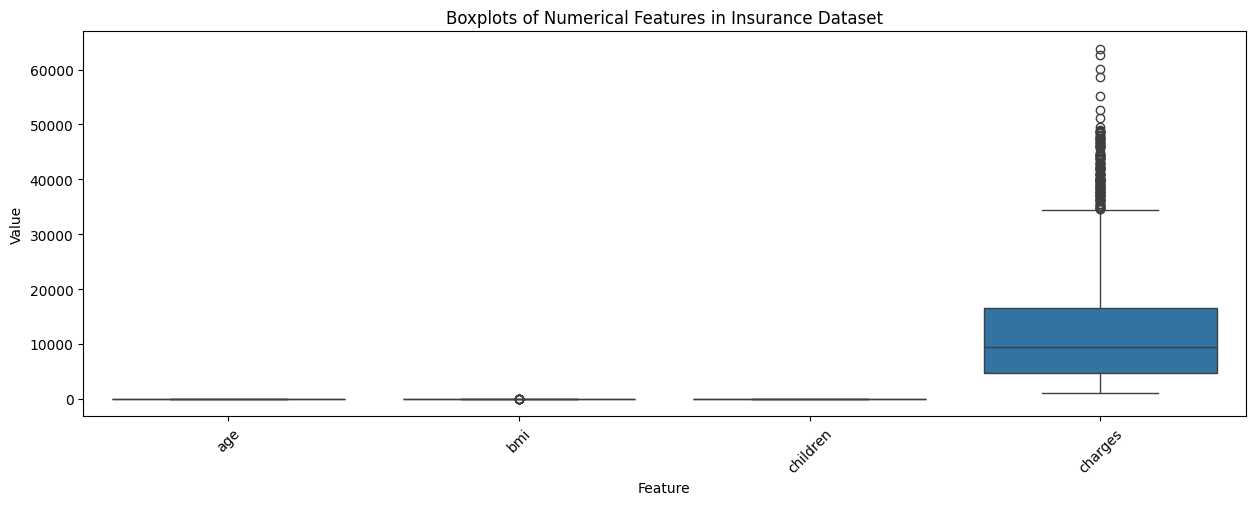

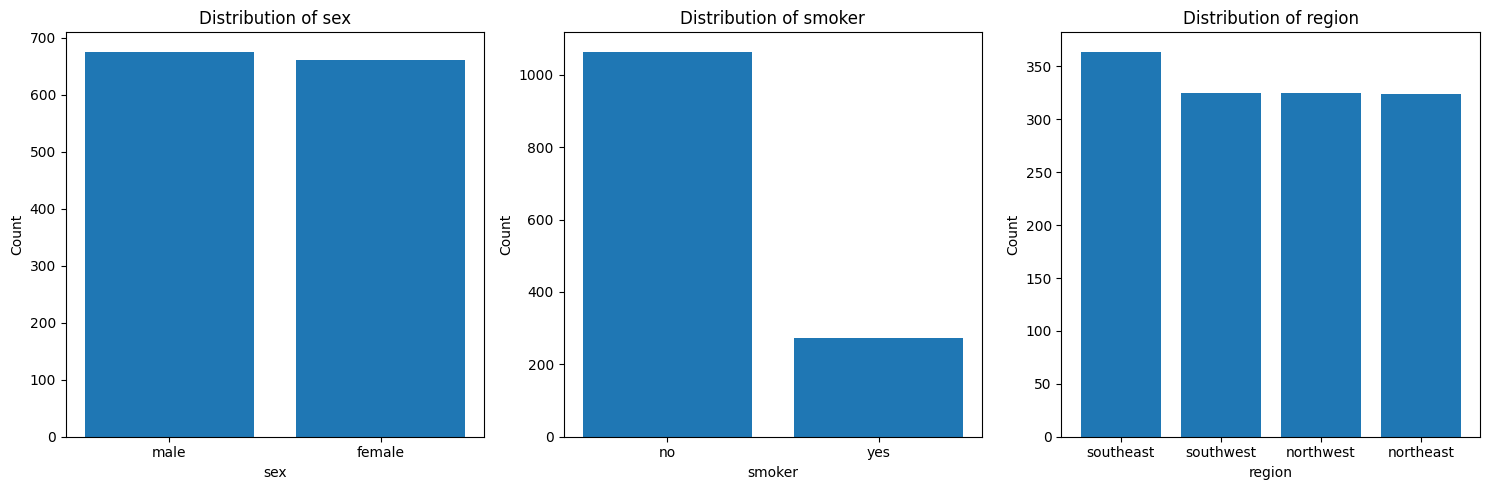

array([[<Axes: title={'center': 'charges'}>]], dtype=object)

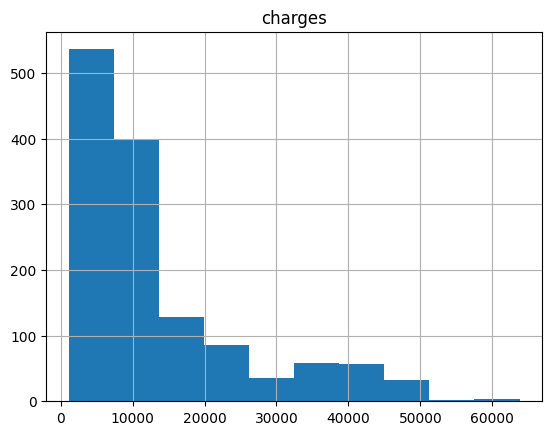

In [75]:
# Melt the DataFrame to long format
numeric_columns = ['age', 'bmi', 'children', 'charges']
cat_columns = ['sex', 'smoker', 'region']
insurance_melted = pd.melt(insurance, id_vars=['sex', 'smoker', 'region'],
                             value_vars=['age', 'bmi', 'children', 'charges'],
                             var_name='Feature', value_name='Value')

# Create the boxplot
plt.figure(figsize=(15, 5))
sns.boxplot(x='Feature', y='Value', data=insurance_melted)
plt.title('Boxplots of Numerical Features in Insurance Dataset')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()

# Create subplots
fig, axes = plt.subplots(1, len(cat_columns), figsize=(15, 5))  # Adjust figsize as needed

# Loop through categorical columns and plot on subplots
for i, column in enumerate(cat_columns):
    value_counts = insurance[column].value_counts()
    axes[i].bar(value_counts.index, value_counts.values)
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')
    #axes[i].tick_params(axis='x', rotation=45, ha='right')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

insurance.hist("charges")

The `charges` column is highly skewed to the right. Extremely costly insurance charges are more common than extremely small ones. This makes it unlikely that the errors in the model will truly be centered at zero. It might be worth it to `log-transform` the outcome.

array([[<Axes: title={'center': 'log_charges'}>]], dtype=object)

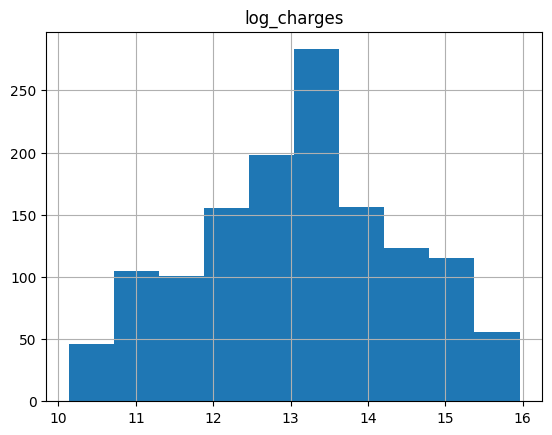

In [76]:
insurance["log_charges"] = np.log2(insurance["charges"])

insurance.hist("log_charges")

The log-transformed `charges` values are more centered, which is what we wanted. This makes it more likely that the errors will be unbiased.

##Feature Engineering

map categorical columns in to values

In [78]:
insurance_modif = insurance.copy()

# replace male with 1, female with 0
insurance_modif['sex'] = insurance_modif['sex'].map(lambda x: 1 if x=='male' else 0)

# replace yes with 1, no with 0
insurance_modif['smoker'] = insurance_modif['smoker'].map(lambda x: 1 if x=='yes' else 0)

# creating dummy variables for region
insurance_modif = pd.get_dummies(data=insurance_modif, columns=['region'], drop_first=True)
insurance_modif.head()

,age,sex,bmi,children,smoker,charges,log_charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,14.043448,False,False,True
1,18,1,33.770,1,0,1725.55230,10.752842,False,True,False
2,28,1,33.000,3,0,4449.46200,12.119415,False,True,False
3,33,1,22.705,0,0,21984.47061,14.424197,True,False,False
4,32,1,28.880,0,0,3866.85520,11.916945,True,False,False


## Correlation Matrix


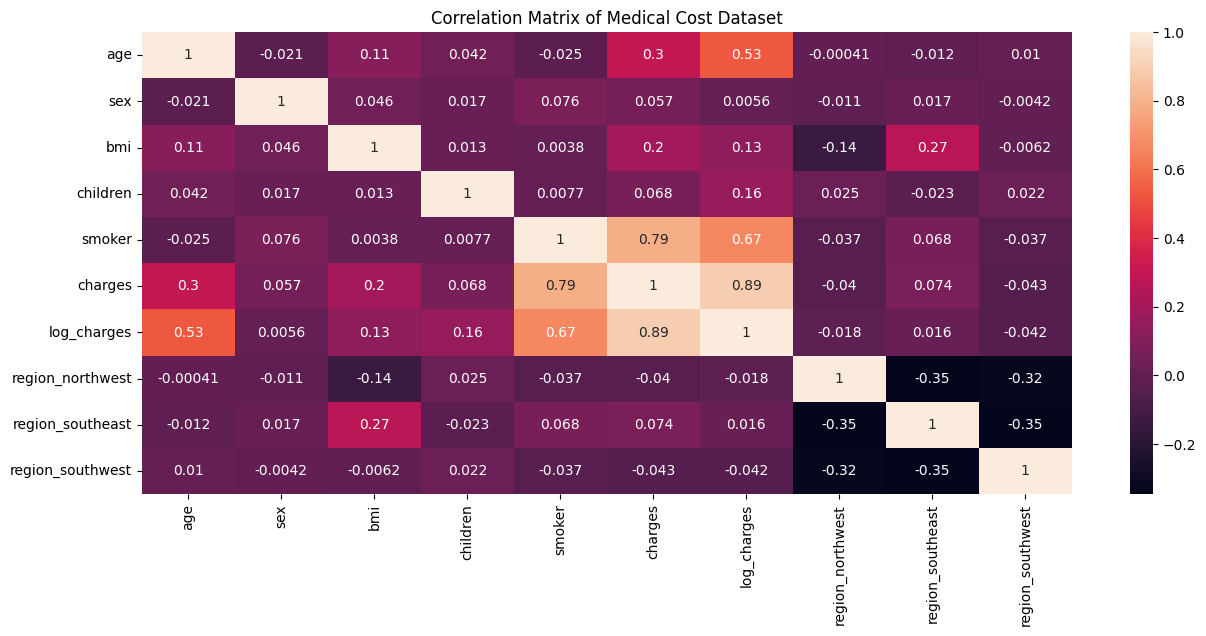

In [79]:
# prompt: gere um uma matriz de correlação com seaborn usando dataset customer

plt.figure(figsize=(15, 6))
sns.heatmap(insurance_modif.corr(), annot=True)
plt.title('Correlation Matrix of Medical Cost Dataset')
plt.show()

## Plot main features vs Log Charges

AGE

BMI

SMOKER

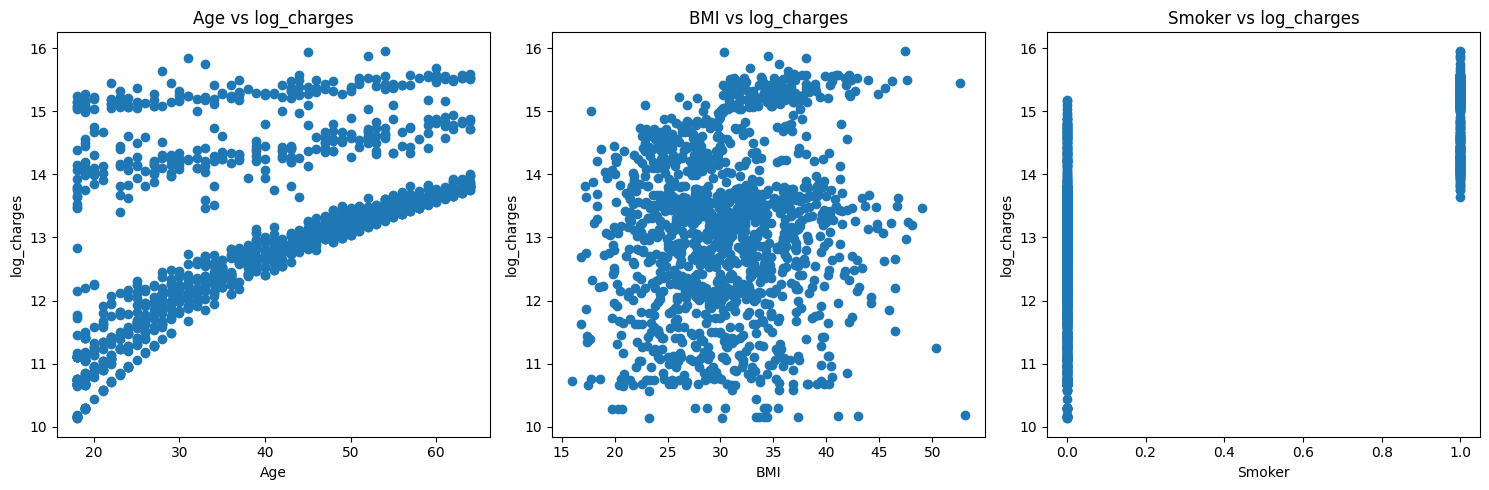

In [80]:
# prompt: generate scatter plot in subplots between age,bmi,smoker vs charges

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Age vs Charges
axes[0].scatter(insurance_modif['age'], insurance_modif['log_charges'])
axes[0].set_xlabel('Age')
axes[0].set_ylabel('log_charges')
axes[0].set_title('Age vs log_charges')

# BMI vs Charges
axes[1].scatter(insurance_modif['bmi'], insurance_modif['log_charges'])
axes[1].set_xlabel('BMI')
axes[1].set_ylabel('log_charges')
axes[1].set_title('BMI vs log_charges')

# Smoker vs Charges
axes[2].scatter(insurance_modif['smoker'], insurance_modif['log_charges'])
axes[2].set_xlabel('Smoker')
axes[2].set_ylabel('log_charges')
axes[2].set_title('Smoker vs log_charges')

plt.tight_layout()
plt.show()


Analyzing correlation matrix we can see that 2 pairs most correlates with each other:

1. log_charges/Smoker - 0.67

1. log_charges/Age  - 0.5

1.  log_charges/BMI - 0.13

From this conclusion we will use this three features to calculate the linear regression to **log_charges**

# Modeling



In [81]:
X = insurance_modif[['smoker','age','bmi']]
y= insurance_modif['log_charges']

#train , test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 1)

## Build Model

In [88]:
#LM object
model = LinearRegression()

#Training predictions
model.fit(X_train,y_train)
train_pred = model.predict(X_train)

#Model coefficients
print("Model Coefficients: ", model.coef_)
print("Model intercept: ", model.intercept_)

# MSE on the original scale for the insurance charges
train_mse = np.exp(mean_squared_error(y_train,train_pred))

print("Train MSE: ",train_mse)

#Coefficent of determination
train_r2 = r2_score(y_train,train_pred)
print("R2: ", train_r2)

Model Coefficients:  [2.23063344 0.04892865 0.01523672]
Model intercept:  10.29374135667316
Train MSE:  1.575647870310887
R2:  0.7421118855283421


###Comments

The training MSE for the model is 0.454 and is 1.57 on the original scale. The
 indicates that the model can explain 74% of the variation in the log-insurance charges. These preliminary results are promising, but we must remember that these are optimistic values.

### Train set conclusion

Knowing that linear regression is ruled by:

$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3$

where,

$\beta_0$ - intercept = 10.29

$\beta_1$ - smoker coefficient = 2.23

$\beta_2$ - age coefficient = 0.04

$\beta_3$ - bmi coefficient = 0.015



1. Do the coefficient values make sense considering their correlation with the outcome?

     - The coeffiencts make sense because the highest correlation with charge is in SMOKER predictors.

1. What does the coefficient of determination suggest about the model fit?

  - R² coefficient of determination suggest that the model in train test fits for **76%** of outcomes

1. How well does the model predict the medical costs in the training set?

## Residual Diagnostics

Recall that the error term $ϵ$ represents how much the outcome $Y$ differs from what is fit by the combination of predictors:

$\epsilon_i = Y_i - \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_p X_p$

$e_i = Y_i - \hat{Y}_i$

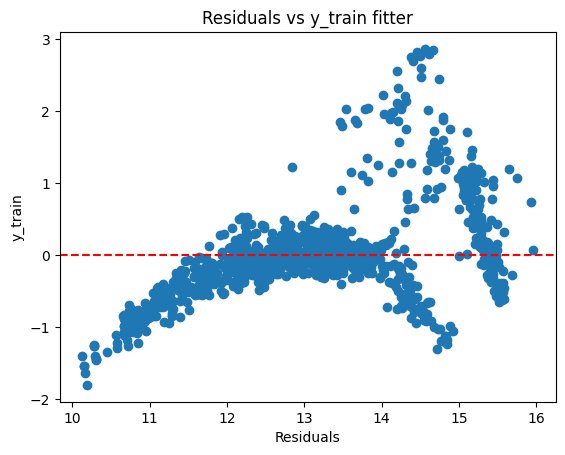

In [83]:
#Calculate the fitted values for all of the data in the training set.
#Use these calculated values to calculate the residuals of the model.

#array of residuals
residuals = y_train - train_pred

plt.scatter(y_train,residuals)
plt.title("Residuals vs y_train fitter")
plt.xlabel("Residuals")
plt.ylabel("y_train")
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

From the graph above we can see that in a range of residuals varying from 0 to 15000 , most of them remain close to y=0 point.

When residuals are aboce 15000 it is possible to see some values away from y=0 point.

# Final Model Evaluation

1. Take the test dataset, and use the model to produce the fitted values.

1. Calculate the mean squared error (MSE) of the test predictions.

1. How does this value compare to what was calculated from the training set?

In [90]:
#Test predictions
test_pred = model.predict(X_test)

#MSE
train_mse = np.exp(mean_squared_error(y_train,train_pred))
test_mse = np.exp(mean_squared_error(y_test,test_pred))

print("Train MSE: ",train_mse)
print("Test MSE: ",test_mse)

#Coefficent of determination
test_r2 = r2_score(y_test,test_pred)
print("R2: ", test_r2)

# convert to a df for a better view
test_vs_train = {"testing": [test_mse, test_r2*100],
                 "training": [train_mse, train_r2*100]}
df = pd.DataFrame(test_vs_train, index=['mse', 'r2'])
df

Train MSE:  1.575647870310887
Test MSE:  1.545789970635098
R2:  0.7502277830580025


,testing,training
mse,1.545790,1.575648
r2,75.022778,74.211189


Test MSE is higher than train MSE. Indicating that the model could not predict **unseend** data properly.

On the other hand, R² reduced from 76% in train set , to 69% in test set

Using the model on the testing dataset, we can see that

* Higher MSE - indicates that the model's predictions on unseen data are less accurate, suggesting some generalization issues.

* Lower R2 - meaning the model explains less variance in the target variable for unseen data.

As a result, this potentially indicate overfitting to some degree, as the model performs better on the training data than on the testing data. However, the differences are not extreme, so the model might still be acceptable.